In [141]:
from google.cloud import storage
from wordcloud import WordCloud
import json
import seaborn as sns
import pandas as pd
from stemming.porter2 import stem
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import unicodedata
import operator
import matplotlib.pyplot as plt
% matplotlib inline

### Download the templates

In [3]:
client = storage.Client(project="users-protection")
bucket = client.get_bucket('up_ml_experimental')
blobs = bucket.list_blobs(prefix="push_template_raw/")
pushTemplates = []
for b in blobs:
    pushTemplates.append(json.loads(b.download_as_string()))

/Users/hchudgar/Documents/dev/up-ml-models/up-env/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [101]:
print("Number of templates: {}".format(len(pushTemplates)))

Number of templates: 219


#### Utility functions

In [131]:
def sortHistogram(x):
    tupleList = sorted(x.items(), key=operator.itemgetter(1))
    return {}


def addToHistogram(word, hist):
    if (word not in hist):
        hist[word] = 0
    hist[word] += 1
    return hist

def getDictionaryFromDF(df):
    df = df.set_index(["word"])
    return df.to_dict()["count"]

def generateWordCloud(wordDictionary):
    wc = WordCloud()
    wci = wc.generate_from_frequencies(frequencies=wordDictionary)
    # The pil way (if you don't have matplotlib)
    image = wci.to_image()
    image.show()

### Generate word histograms for English templates

1. Message body

In [51]:
englishStopWords = set(stopwords.words('english'))

wordHistogram = {}
stopWordsHistogram = {}
parameterizedMessages = []
moustacheWords = {}

for template in pushTemplates:
    if ("en" not in template["data"]["templates"]):
        continue
    message = template["data"]["templates"]["en"]["message"].lower()
    message = unicodedata.normalize('NFKD', message).encode('ascii','ignore')
    if("{{" in message):
        parameterizedMessages.append(message)
    for word in message.split(" "):
        # Do not count if stop word
        if (word in englishStopWords):
            stopWordsHistogram = addToHistogram(word, stopWordsHistogram)
            continue
        if ("{{" in word):
            moustacheWords = addToHistogram(word, moustacheWords)
        else:
            # Stem word and add to dictionary
            wordHistogram = addToHistogram(stem(word), wordHistogram)

2. Titles

In [52]:
parameterizedTitles = []

for template in pushTemplates:
    if ("en" not in template["data"]["templates"]):
        continue
    title = template["data"]["templates"]["en"]["title"].lower()
    title = unicodedata.normalize('NFKD', title).encode('ascii','ignore')
    if("{{" in message):
        parameterizedTitles.append(title)
    for word in message.split(" "):
        # Do not count if stop word
        if (word in englishStopWords):
            stopWordsHistogram = addToHistogram(word, stopWordsHistogram)
            continue
        if ("{{" in word):
            moustacheWords = addToHistogram(word, moustacheWords)
        else:
            # Stem word and add to dictionary
            wordHistogram = addToHistogram(stem(word), wordHistogram)

### Some word statistics

In [106]:
print("Number of unique words: {}".format(len(wordHistogram)))
print("Number of parametrized messages: {}".format(len(parameterizedMessages)))
print("Number of parametrized titles: {}".format(len(parameterizedTitles)))
print("Number of moustache words: {}".format(len(moustacheWords)))
print("Number of stop words in templates: {}".format(len(stopWordsHistogram)))

Number of unique words: 431
Number of parametrized messages: 38
Number of parametrized titles: 0
Number of moustache words: 31
Number of stop words in templates: 52


### Parameterized Messages

In [107]:
parameterizedMessages

['hear the latest music from {{artistname}} and more artists you like, updated every friday.',
 '{{display-name}}, {{artist-name}} released a new album entitled {{album-name}} this week on spotify!',
 'get 3 months of premium for {{offerprice}} this season! ',
 '2 accounts for couples under one roof, {{duoprice}}/mo.',
 '2 accounts for couples under one roof, {{duoprice}}/mo.',
 'only {{duoprice}}/mo for 2 premium accounts.',
 'save by switching to duo: 2 accounts, {{duoprice}}/mo.',
 'a year ago, you had {{artist_1_name}} on heavy rotation. play them again?',
 'remember {{artist_2_name}} from this time last year? dive back in! ',
 "songs by {{artist_name}} and others we think you'll enjoy.  tap to listen.",
 'its that time again... relive last years memories with {{artist_3_name}}.',
 '2 accounts for couples under one roof, {{duoprice}}/mo. try it free for 30 days.',
 'dive into {{show_name}}, a new podcast we think youll enjoy.  tap to listen.',
 'just add a few songs to {{target_nam

### Word variety and counts

More than 50% of words occur only once, and only 12% of the words appearing ≥ 5 times

Text(0.5,1,'Number of words with count >= x')

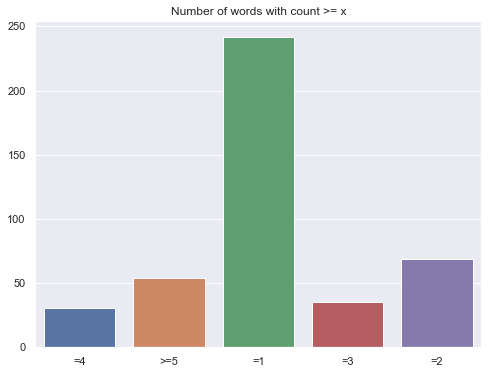

In [149]:
wordVarietyHistogram = {}

wordVarietyHistogram["=1"] = len(wordDF[wordDF["count"] == 1])
wordVarietyHistogram["=2"] = len(wordDF[wordDF["count"] == 2])
wordVarietyHistogram["=3"] = len(wordDF[wordDF["count"] == 3])
wordVarietyHistogram["=4"] = len(wordDF[wordDF["count"] == 4])
wordVarietyHistogram[">=5"] = len(wordDF[wordDF["count"] >= 5])

sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale=1)

ax = sns.barplot(y=wordVarietyHistogram.values(), x=wordVarietyHistogram.keys())
ax.set_title("Number of words with count >= x")

In [151]:
wordVarietyHistogram

{'=1': 242, '=2': 69, '=3': 35, '=4': 31, '>=5': 54}

### Moustache words

There are about 30 moustache/parameter words. They can be categorized into the following:
1. Pricing related
2. Album names
3. Artist names
4. Time

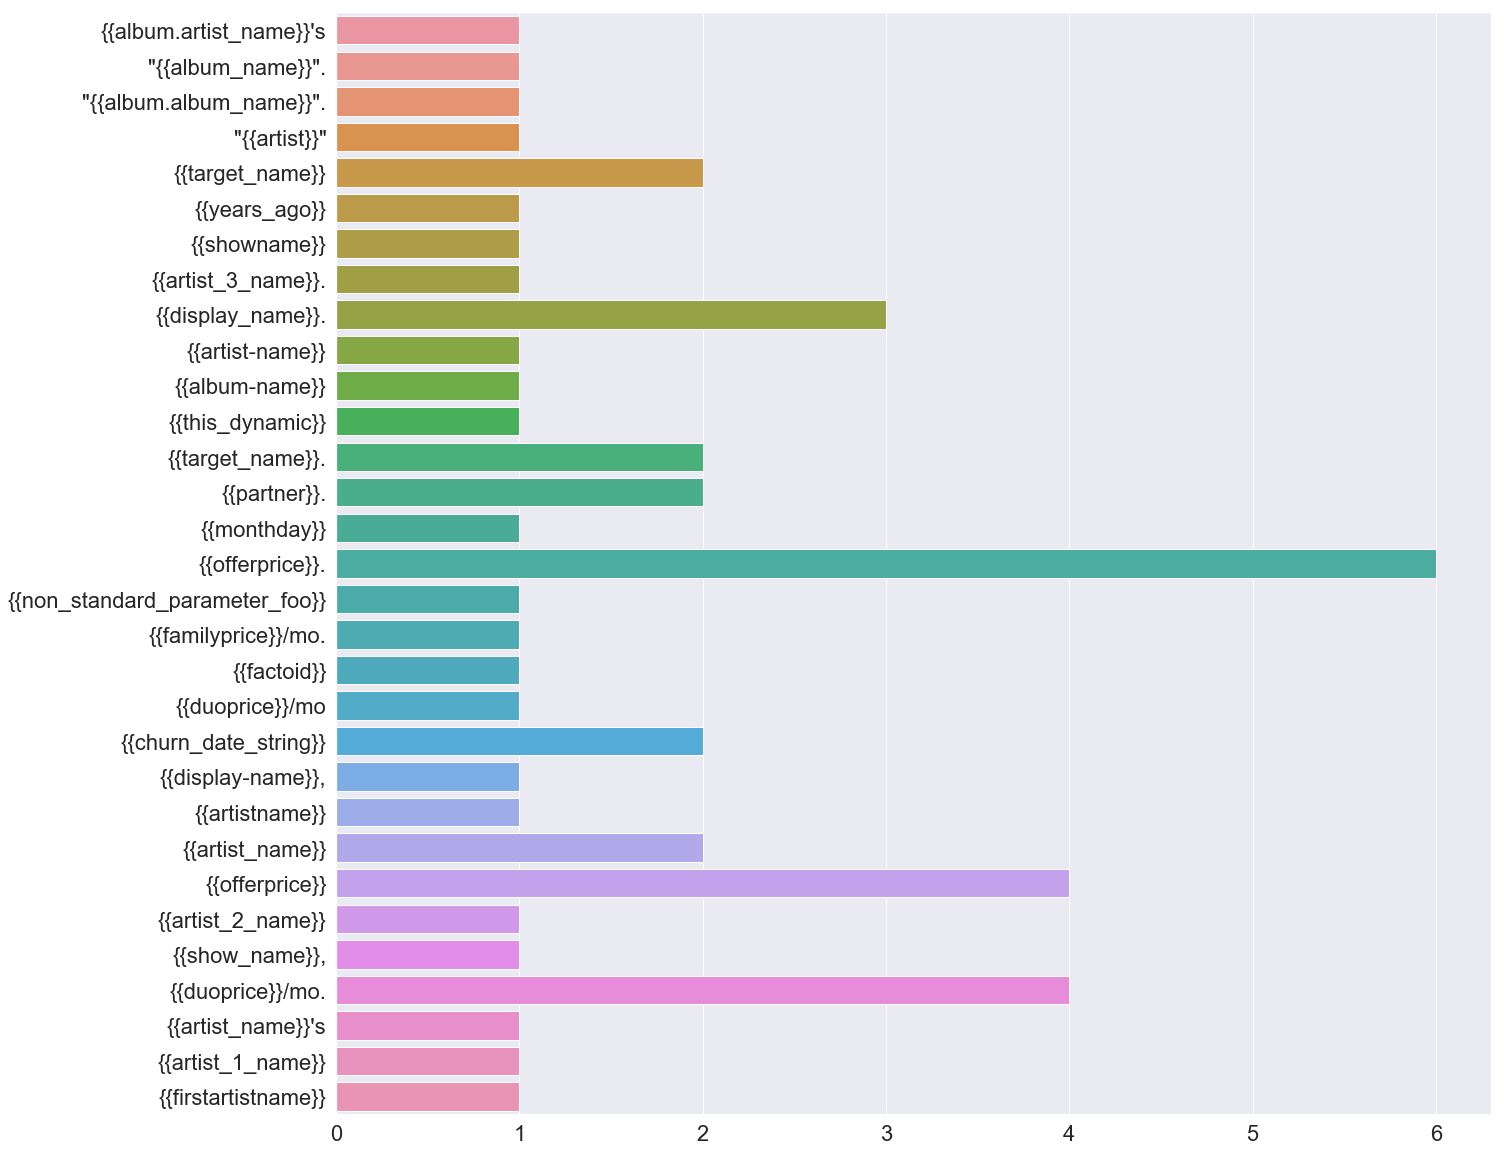

In [59]:
sns.set(rc={'figure.figsize':(20.7,20.27)})
sns.set(font_scale=2)
sns.barplot(x=moustacheWords.values(), y=moustacheWords.keys())

### Word cloud and histogram of words occuring ≥ 5 times

In [156]:
wordDF = pd.DataFrame(index=wordHistogram.keys(), data=wordHistogram.values(), columns=["count"])
wordDF = wordDF.reset_index()
wordDF = wordDF.rename(index=str, columns={"index": "word", "count": "count"})
wordDF = wordDF.sort_values(by="count", ascending=False)

moreThanFiveOccurences = getDictionaryFromDF(wordDF[wordDF["count"] >= 5])

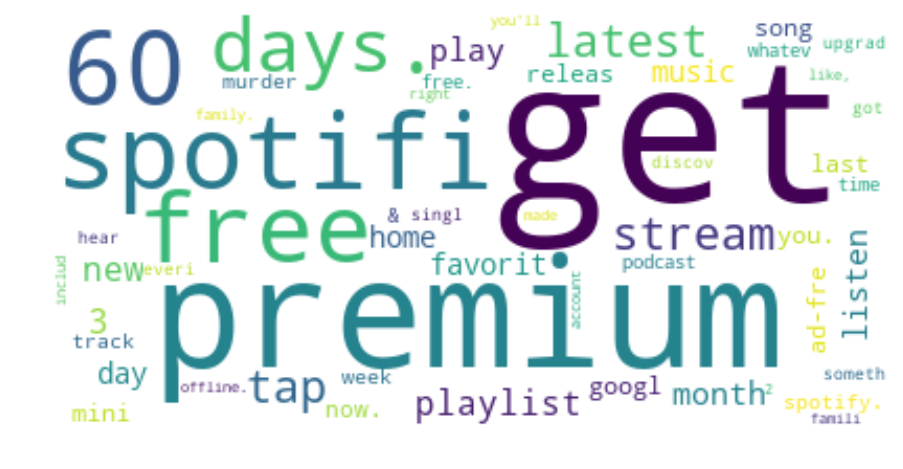

In [157]:
wc = WordCloud(background_color="white")
wci = wc.generate_from_frequencies(frequencies=moreThanFiveOccurences)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wci, interpolation='bilinear')
plt.axis("off")
plt.show()

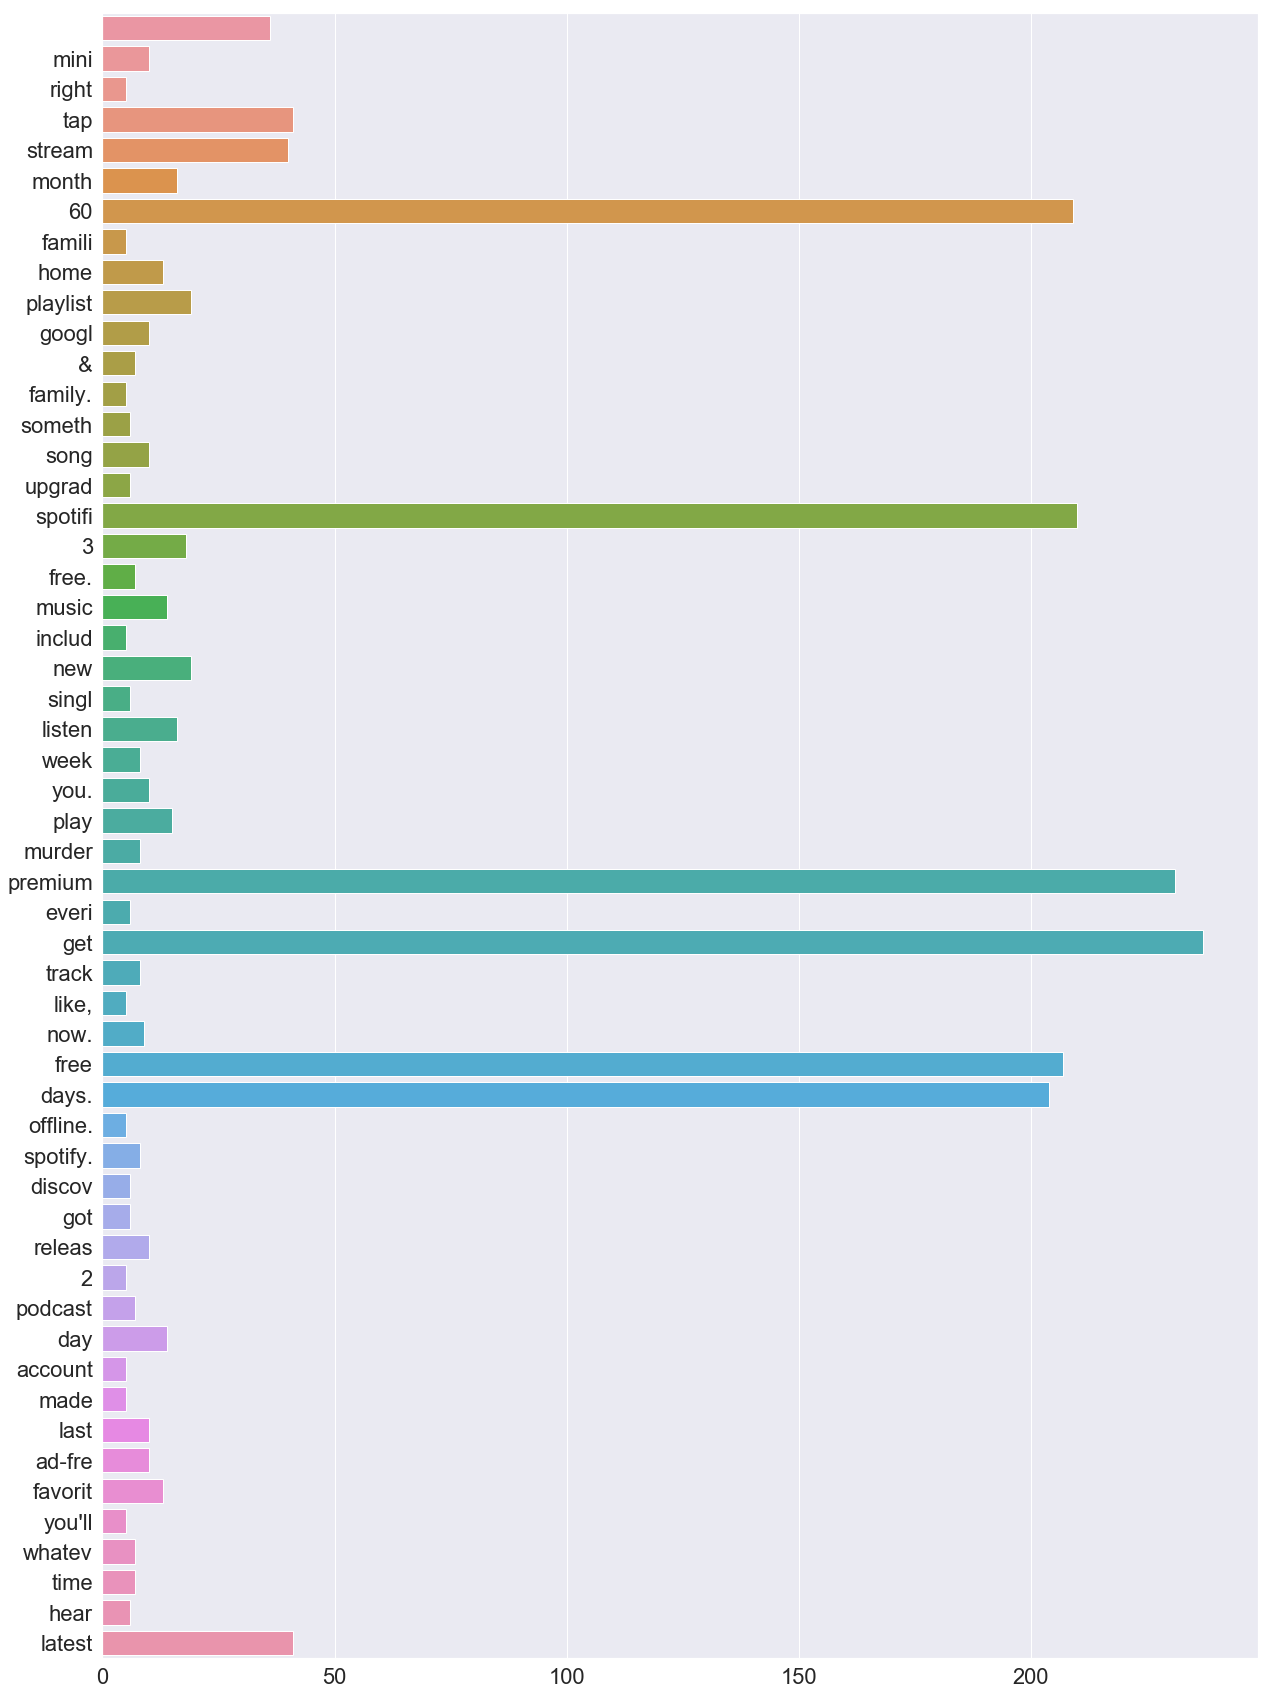

In [158]:
sns.set(rc={'figure.figsize':(20.7,30.27)})
sns.set(font_scale=2)
sns.barplot(x=moreThanFiveOccurences.values(), y=moreThanFiveOccurences.keys())